In [1]:
import scanpy as sc
import squidpy as sq

import numpy as np
import pandas as pd

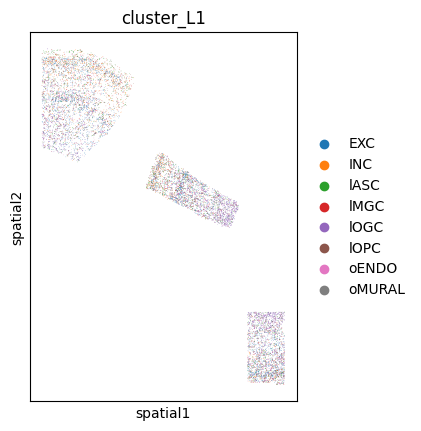

In [2]:
adata_stg = sc.read_h5ad('../stg_baselines.h5ad')
sc.pp.normalize_total(adata_stg)
sc.pp.log1p(adata_stg)

adata_stg.obsm['spatial'][adata_stg.obs['batch']==adata_stg.obs['batch'].unique()[0]] -= 5000
adata_stg.obsm['spatial'][adata_stg.obs['batch']==adata_stg.obs['batch'].unique()[2]] += 5000

sc.pl.spatial(adata_stg,color=['cluster_L1'],spot_size = 30)

In [4]:
from model import SpiceMix
from sklearn.neighbors import kneighbors_graph
import torch
K, num_pcs, n_neighbors, res_lo, res_hi = 20, 20, 10, .5, 2.
context = dict(device='cuda:1', dtype=torch.float64)

repli_list = ['H20.30.001.STG.4000.rep1','H20.30.001.STG.4000.rep2','H20.30.001.STG.4000.rep3']

A1 = kneighbors_graph(adata_stg[adata_stg.obs['batch']==repli_list[0]].obsm['spatial'],n_neighbors = 10)
A2 = kneighbors_graph(adata_stg[adata_stg.obs['batch']==repli_list[1]].obsm['spatial'],n_neighbors = 10)
A3 = kneighbors_graph(adata_stg[adata_stg.obs['batch']==repli_list[2]].obsm['spatial'],n_neighbors = 10)

from pytorch_lightning.utilities.seed import seed_everything
for i in range(10):
    seed_everything(i)
    print(i)
    obj = SpiceMix(
    K=20,
    lambda_Sigma_x_inv=1e-6, power_Sigma_x_inv=2,
    repli_list=repli_list,
    context=context,
    context_Y=context,
    )
    obj.Ys = [adata_stg[adata_stg.obs['batch']==repli_list[0]].X,adata_stg[adata_stg.obs['batch']==repli_list[1]].X,adata_stg[adata_stg.obs['batch']==repli_list[2]].X]
    obj.Gs = [4000,4000,4000]
    obj.GG = 4000
    obj.Ys = [G / obj.GG * K * Y / Y.sum(1).mean() for Y, G in zip(obj.Ys, obj.Gs)]
    obj.Ys = [torch.tensor(Y, **context).pin_memory() 
               if context['device'] != 'cpu' and context['device'] == 'cpu' else
               torch.tensor(Y, **context) for Y in obj.Ys]
    obj.Es = [np.vstack((A1.tocoo().row, A1.tocoo().col)).T, np.vstack((A2.tocoo().row, A2.tocoo().col)).T, np.vstack((A3.tocoo().row, A3.tocoo().col)).T]
    obj.Es_isempty = [True, True, True]

    obj.initialize(method='kmeans',random_state=i)
    for iiter in range(10):
        obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
        obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.initialize_Sigma_x_inv()
    for iiter in range(1, 101):
        obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
        obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)
    adata_stg.obsm['spicemix'+str(i)] = torch.cat(obj.Xs).cpu().numpy()
    np.save('../Benchmarking_results/STG/'+'spicemix'+str(i)+'.npy',adata_stg.obsm['spicemix'+str(i)])

Global seed set to 0


0


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 06:25:15:INFO:Updating latent states
2024-03-24 06:25:17:INFO:Updating model parameters
2024-03-24 06:25:25:INFO:Q value = nan
2024-03-24 06:25:25:INFO:Updating latent states
2024-03-24 06:25:26:INFO:Updating model parameters
2024-03-24 06:25:30:INFO:Q value = nan
2024-03-24 06:25:30:INFO:Updating latent states
2024-03-24 06:25:31:INFO:Updating model parameters
2024-03-24 06:25:35:INFO:Q value = nan
2024-03-24 06:25:35:INFO:Updating latent states
2024-03-24 06:25:36:INFO:Updating model parameters
2024-03-24 06:25:40:INFO:Q value = nan
2024-03-24 06:25:40:INFO:Updating latent states
2024-03-24 06:25:41:INFO:Updating model parameters
2024-03-24 06:25:44:INFO:Q value = nan
2024-03-24 06:25:44:INFO:Updating latent states
2024-03-24 06:25:45:INFO:Updat

2024-03-24 06:35:58:INFO:Updating model parameters
2024-03-24 06:36:09:INFO:Q value = -33267428.763042852
2024-03-24 06:36:09:INFO:Updating latent states
2024-03-24 06:36:10:INFO:Updating model parameters
2024-03-24 06:36:29:INFO:Q value = -33265983.491447497
2024-03-24 06:36:29:INFO:Updating latent states
2024-03-24 06:36:30:INFO:Updating model parameters
2024-03-24 06:36:47:INFO:Q value = -33265181.364912216
2024-03-24 06:36:47:INFO:Updating latent states
2024-03-24 06:36:48:INFO:Updating model parameters
2024-03-24 06:37:00:INFO:Q value = -33264742.607903995
2024-03-24 06:37:00:INFO:Updating latent states
2024-03-24 06:37:00:INFO:Updating model parameters
2024-03-24 06:37:09:INFO:Q value = -33264843.10162807
2024-03-24 06:37:09:INFO:Updating latent states
2024-03-24 06:37:09:INFO:Updating model parameters
2024-03-24 06:37:22:INFO:Q value = -33264620.94670491
2024-03-24 06:37:22:INFO:Updating latent states
2024-03-24 06:37:22:INFO:Updating model parameters
2024-03-24 06:37:31:INFO:Q 

2024-03-24 06:51:15:INFO:Updating latent states
2024-03-24 06:51:15:INFO:Updating model parameters
2024-03-24 06:51:22:INFO:Q value = -33244451.38166825
2024-03-24 06:51:22:INFO:Updating latent states
2024-03-24 06:51:22:INFO:Updating model parameters
2024-03-24 06:51:29:INFO:Q value = -33244412.18652093
2024-03-24 06:51:29:INFO:Updating latent states
2024-03-24 06:51:29:INFO:Updating model parameters
2024-03-24 06:51:35:INFO:Q value = -33244393.797132447
2024-03-24 06:51:35:INFO:Updating latent states
Global seed set to 1


1


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 06:51:54:INFO:Updating latent states
2024-03-24 06:51:56:INFO:Updating model parameters
2024-03-24 06:52:00:INFO:Q value = nan
2024-03-24 06:52:00:INFO:Updating latent states
2024-03-24 06:52:01:INFO:Updating model parameters
2024-03-24 06:52:03:INFO:Q value = nan
2024-03-24 06:52:03:INFO:Updating latent states
2024-03-24 06:52:04:INFO:Updating model parameters
2024-03-24 06:52:06:INFO:Q value = nan
2024-03-24 06:52:06:INFO:Updating latent states
2024-03-24 06:52:07:INFO:Updating model parameters
2024-03-24 06:52:08:INFO:Q value = nan
2024-03-24 06:52:08:INFO:Updating latent states
2024-03-24 06:52:09:INFO:Updating model parameters
2024-03-24 06:52:10:INFO:Q value = nan
2024-03-24 06:52:10:INFO:Updating latent states
2024-03-24 06:52:10:INFO:Updat

2024-03-24 06:57:13:INFO:Updating model parameters
2024-03-24 06:57:21:INFO:Q value = -33268469.305839267
2024-03-24 06:57:21:INFO:Updating latent states
2024-03-24 06:57:21:INFO:Updating model parameters
2024-03-24 06:57:26:INFO:Q value = -33268188.50348082
2024-03-24 06:57:26:INFO:Updating latent states
2024-03-24 06:57:26:INFO:Updating model parameters
2024-03-24 06:57:30:INFO:Q value = -33268185.975457266
2024-03-24 06:57:30:INFO:Updating latent states
2024-03-24 06:57:30:INFO:Updating model parameters
2024-03-24 06:57:35:INFO:Q value = -33268292.63855549
2024-03-24 06:57:35:INFO:Updating latent states
2024-03-24 06:57:35:INFO:Updating model parameters
2024-03-24 06:57:42:INFO:Q value = -33268142.230565358
2024-03-24 06:57:42:INFO:Updating latent states
2024-03-24 06:57:42:INFO:Updating model parameters
2024-03-24 06:57:49:INFO:Q value = -33268104.808473006
2024-03-24 06:57:49:INFO:Updating latent states
2024-03-24 06:57:49:INFO:Updating model parameters
2024-03-24 06:57:57:INFO:Q 

2024-03-24 07:07:09:INFO:Q value = -33247063.982837386
2024-03-24 07:07:09:INFO:Updating latent states
2024-03-24 07:07:09:INFO:Updating model parameters
2024-03-24 07:07:13:INFO:Q value = -33247030.310294706
2024-03-24 07:07:13:INFO:Updating latent states
2024-03-24 07:07:13:INFO:Updating model parameters
2024-03-24 07:07:17:INFO:Q value = -33247004.403319445
2024-03-24 07:07:17:INFO:Updating latent states
2024-03-24 07:07:17:INFO:Updating model parameters
2024-03-24 07:07:20:INFO:Q value = -33246973.96223041
2024-03-24 07:07:20:INFO:Updating latent states
Global seed set to 2


2


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 07:07:42:INFO:Updating latent states
2024-03-24 07:07:45:INFO:Updating model parameters
2024-03-24 07:07:52:INFO:Q value = nan
2024-03-24 07:07:52:INFO:Updating latent states
2024-03-24 07:07:53:INFO:Updating model parameters
2024-03-24 07:07:57:INFO:Q value = nan
2024-03-24 07:07:57:INFO:Updating latent states
2024-03-24 07:07:58:INFO:Updating model parameters
2024-03-24 07:08:04:INFO:Q value = nan
2024-03-24 07:08:04:INFO:Updating latent states
2024-03-24 07:08:04:INFO:Updating model parameters
2024-03-24 07:08:09:INFO:Q value = nan
2024-03-24 07:08:09:INFO:Updating latent states
2024-03-24 07:08:09:INFO:Updating model parameters
2024-03-24 07:08:14:INFO:Q value = nan
2024-03-24 07:08:14:INFO:Updating latent states
2024-03-24 07:08:14:INFO:Updat

2024-03-24 07:16:13:INFO:Updating model parameters
2024-03-24 07:16:29:INFO:Q value = -33264574.638843358
2024-03-24 07:16:29:INFO:Updating latent states
2024-03-24 07:16:29:INFO:Updating model parameters
2024-03-24 07:16:37:INFO:Q value = -33264160.016419113
2024-03-24 07:16:37:INFO:Updating latent states
2024-03-24 07:16:37:INFO:Updating model parameters
2024-03-24 07:16:44:INFO:Q value = -33264008.70172653
2024-03-24 07:16:44:INFO:Updating latent states
2024-03-24 07:16:44:INFO:Updating model parameters
2024-03-24 07:16:50:INFO:Q value = -33263912.809387777
2024-03-24 07:16:50:INFO:Updating latent states
2024-03-24 07:16:50:INFO:Updating model parameters
2024-03-24 07:16:57:INFO:Q value = -33263892.575961728
2024-03-24 07:16:57:INFO:Updating latent states
2024-03-24 07:16:57:INFO:Updating model parameters
2024-03-24 07:17:07:INFO:Q value = -33263186.75385483
2024-03-24 07:17:07:INFO:Updating latent states
2024-03-24 07:17:07:INFO:Updating model parameters
2024-03-24 07:17:31:INFO:Q 

2024-03-24 07:26:56:INFO:Updating latent states
2024-03-24 07:26:56:INFO:Updating model parameters
2024-03-24 07:26:59:INFO:Q value = -33241059.682228565
2024-03-24 07:26:59:INFO:Updating latent states
2024-03-24 07:27:00:INFO:Updating model parameters
2024-03-24 07:27:03:INFO:Q value = -33241054.271299668
2024-03-24 07:27:03:INFO:Updating latent states
2024-03-24 07:27:03:INFO:Updating model parameters
2024-03-24 07:27:06:INFO:Q value = -33241047.322113097
2024-03-24 07:27:07:INFO:Updating latent states
Global seed set to 3


3


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 07:27:34:INFO:Updating latent states
2024-03-24 07:27:38:INFO:Updating model parameters
2024-03-24 07:27:46:INFO:Q value = nan
2024-03-24 07:27:46:INFO:Updating latent states
2024-03-24 07:27:48:INFO:Updating model parameters
2024-03-24 07:27:54:INFO:Q value = nan
2024-03-24 07:27:54:INFO:Updating latent states
2024-03-24 07:27:55:INFO:Updating model parameters
2024-03-24 07:28:00:INFO:Q value = nan
2024-03-24 07:28:00:INFO:Updating latent states
2024-03-24 07:28:01:INFO:Updating model parameters
2024-03-24 07:28:06:INFO:Q value = nan
2024-03-24 07:28:06:INFO:Updating latent states
2024-03-24 07:28:07:INFO:Updating model parameters
2024-03-24 07:28:12:INFO:Q value = nan
2024-03-24 07:28:12:INFO:Updating latent states
2024-03-24 07:28:12:INFO:Updat

2024-03-24 07:38:16:INFO:Updating model parameters
2024-03-24 07:38:27:INFO:Q value = -33262254.186500277
2024-03-24 07:38:27:INFO:Updating latent states
2024-03-24 07:38:27:INFO:Updating model parameters
2024-03-24 07:38:34:INFO:Q value = -33262228.06445454
2024-03-24 07:38:34:INFO:Updating latent states
2024-03-24 07:38:34:INFO:Updating model parameters
2024-03-24 07:38:45:INFO:Q value = -33261968.152528737
2024-03-24 07:38:45:INFO:Updating latent states
2024-03-24 07:38:45:INFO:Updating model parameters
2024-03-24 07:38:53:INFO:Q value = -33261949.21143251
2024-03-24 07:38:53:INFO:Updating latent states
2024-03-24 07:38:53:INFO:Updating model parameters
2024-03-24 07:38:59:INFO:Q value = -33261814.39351581
2024-03-24 07:38:59:INFO:Updating latent states
2024-03-24 07:39:00:INFO:Updating model parameters
2024-03-24 07:39:07:INFO:Q value = -33261577.240755428
2024-03-24 07:39:07:INFO:Updating latent states
2024-03-24 07:39:07:INFO:Updating model parameters
2024-03-24 07:39:14:INFO:Q v

2024-03-24 07:46:36:INFO:Updating latent states
2024-03-24 07:46:36:INFO:Updating model parameters
2024-03-24 07:46:45:INFO:Q value = -33254207.151103716
2024-03-24 07:46:45:INFO:Updating latent states
2024-03-24 07:46:45:INFO:Updating model parameters
2024-03-24 07:46:52:INFO:Q value = -33254164.267095044
2024-03-24 07:46:53:INFO:Updating latent states
2024-03-24 07:46:53:INFO:Updating model parameters
2024-03-24 07:46:59:INFO:Q value = -33254156.909197617
2024-03-24 07:46:59:INFO:Updating latent states
Global seed set to 4


4


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 07:47:20:INFO:Updating latent states
2024-03-24 07:47:23:INFO:Updating model parameters
2024-03-24 07:47:28:INFO:Q value = nan
2024-03-24 07:47:28:INFO:Updating latent states
2024-03-24 07:47:29:INFO:Updating model parameters
2024-03-24 07:47:34:INFO:Q value = nan
2024-03-24 07:47:34:INFO:Updating latent states
2024-03-24 07:47:35:INFO:Updating model parameters
2024-03-24 07:47:39:INFO:Q value = nan
2024-03-24 07:47:39:INFO:Updating latent states
2024-03-24 07:47:39:INFO:Updating model parameters
2024-03-24 07:47:42:INFO:Q value = nan
2024-03-24 07:47:42:INFO:Updating latent states
2024-03-24 07:47:43:INFO:Updating model parameters
2024-03-24 07:47:46:INFO:Q value = nan
2024-03-24 07:47:46:INFO:Updating latent states
2024-03-24 07:47:46:INFO:Updat

2024-03-24 07:57:21:INFO:Updating model parameters
2024-03-24 07:57:30:INFO:Q value = -33257945.82000655
2024-03-24 07:57:30:INFO:Updating latent states
2024-03-24 07:57:30:INFO:Updating model parameters
2024-03-24 07:58:47:INFO:Q value = -33253231.542918663
2024-03-24 07:58:47:INFO:Updating latent states
2024-03-24 07:58:48:INFO:Updating model parameters
2024-03-24 07:58:55:INFO:Q value = -33253175.170662023
2024-03-24 07:58:55:INFO:Updating latent states
2024-03-24 07:58:55:INFO:Updating model parameters
2024-03-24 07:59:14:INFO:Q value = -33252612.77366553
2024-03-24 07:59:14:INFO:Updating latent states
2024-03-24 07:59:14:INFO:Updating model parameters
2024-03-24 07:59:53:INFO:Q value = -33251770.171277717
2024-03-24 07:59:53:INFO:Updating latent states
2024-03-24 07:59:53:INFO:Updating model parameters
2024-03-24 08:00:00:INFO:Q value = -33251736.129238248
2024-03-24 08:00:00:INFO:Updating latent states
2024-03-24 08:00:00:INFO:Updating model parameters
2024-03-24 08:00:06:INFO:Q 

2024-03-24 08:09:26:INFO:Q value = -33245455.652057387
2024-03-24 08:09:26:INFO:Updating latent states
2024-03-24 08:09:26:INFO:Updating model parameters
2024-03-24 08:09:35:INFO:Q value = -33245426.72268847
2024-03-24 08:09:35:INFO:Updating latent states
2024-03-24 08:09:35:INFO:Updating model parameters
2024-03-24 08:09:39:INFO:Q value = -33245403.72255544
2024-03-24 08:09:39:INFO:Updating latent states
2024-03-24 08:09:39:INFO:Updating model parameters
2024-03-24 08:09:46:INFO:Q value = -33245378.787557136
2024-03-24 08:09:46:INFO:Updating latent states
Global seed set to 5


5


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 08:10:25:INFO:Updating latent states
2024-03-24 08:10:30:INFO:Updating model parameters
2024-03-24 08:10:39:INFO:Q value = nan
2024-03-24 08:10:39:INFO:Updating latent states
2024-03-24 08:10:43:INFO:Updating model parameters
2024-03-24 08:10:49:INFO:Q value = nan
2024-03-24 08:10:49:INFO:Updating latent states
2024-03-24 08:10:51:INFO:Updating model parameters
2024-03-24 08:10:55:INFO:Q value = nan
2024-03-24 08:10:55:INFO:Updating latent states
2024-03-24 08:10:57:INFO:Updating model parameters
2024-03-24 08:11:01:INFO:Q value = nan
2024-03-24 08:11:01:INFO:Updating latent states
2024-03-24 08:11:03:INFO:Updating model parameters
2024-03-24 08:11:06:INFO:Q value = nan
2024-03-24 08:11:06:INFO:Updating latent states
2024-03-24 08:11:07:INFO:Updat

2024-03-24 08:19:47:INFO:Updating model parameters
2024-03-24 08:19:56:INFO:Q value = -33271052.218026266
2024-03-24 08:19:56:INFO:Updating latent states
2024-03-24 08:19:56:INFO:Updating model parameters
2024-03-24 08:20:04:INFO:Q value = -33270967.00848654
2024-03-24 08:20:04:INFO:Updating latent states
2024-03-24 08:20:04:INFO:Updating model parameters
2024-03-24 08:20:21:INFO:Q value = -33270658.734946087
2024-03-24 08:20:21:INFO:Updating latent states
2024-03-24 08:20:21:INFO:Updating model parameters
2024-03-24 08:20:33:INFO:Q value = -33270641.299822345
2024-03-24 08:20:33:INFO:Updating latent states
2024-03-24 08:20:33:INFO:Updating model parameters
2024-03-24 08:20:46:INFO:Q value = -33270198.58285143
2024-03-24 08:20:46:INFO:Updating latent states
2024-03-24 08:20:46:INFO:Updating model parameters
2024-03-24 08:20:59:INFO:Q value = -33269693.292627756
2024-03-24 08:20:59:INFO:Updating latent states
2024-03-24 08:20:59:INFO:Updating model parameters
2024-03-24 08:21:06:INFO:Q 

2024-03-24 08:29:55:INFO:Updating latent states
2024-03-24 08:29:55:INFO:Updating model parameters
2024-03-24 08:30:01:INFO:Q value = -33256581.992515225
2024-03-24 08:30:01:INFO:Updating latent states
2024-03-24 08:30:01:INFO:Updating model parameters
2024-03-24 08:30:06:INFO:Q value = -33256594.29852562
2024-03-24 08:30:06:INFO:Updating latent states
2024-03-24 08:30:06:INFO:Updating model parameters
2024-03-24 08:30:14:INFO:Q value = -33256583.907865185
2024-03-24 08:30:14:INFO:Updating latent states
Global seed set to 6


6


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 08:30:41:INFO:Updating latent states
2024-03-24 08:30:45:INFO:Updating model parameters
2024-03-24 08:31:00:INFO:Q value = nan
2024-03-24 08:31:01:INFO:Updating latent states
2024-03-24 08:31:03:INFO:Updating model parameters
2024-03-24 08:31:17:INFO:Q value = nan
2024-03-24 08:31:17:INFO:Updating latent states
2024-03-24 08:31:19:INFO:Updating model parameters
2024-03-24 08:31:31:INFO:Q value = nan
2024-03-24 08:31:31:INFO:Updating latent states
2024-03-24 08:31:33:INFO:Updating model parameters
2024-03-24 08:31:44:INFO:Q value = nan
2024-03-24 08:31:44:INFO:Updating latent states
2024-03-24 08:31:46:INFO:Updating model parameters
2024-03-24 08:31:56:INFO:Q value = nan
2024-03-24 08:31:56:INFO:Updating latent states
2024-03-24 08:31:57:INFO:Updat

2024-03-24 08:47:07:INFO:Updating model parameters
2024-03-24 08:47:30:INFO:Q value = -33265237.688043
2024-03-24 08:47:30:INFO:Updating latent states
2024-03-24 08:47:31:INFO:Updating model parameters
2024-03-24 08:47:49:INFO:Q value = -33265247.913555488
2024-03-24 08:47:49:INFO:Updating latent states
2024-03-24 08:47:50:INFO:Updating model parameters
2024-03-24 08:48:10:INFO:Q value = -33264807.831495576
2024-03-24 08:48:10:INFO:Updating latent states
2024-03-24 08:48:10:INFO:Updating model parameters
2024-03-24 08:48:27:INFO:Q value = -33264423.086356882
2024-03-24 08:48:27:INFO:Updating latent states
2024-03-24 08:48:27:INFO:Updating model parameters
2024-03-24 08:48:46:INFO:Q value = -33264035.626510575
2024-03-24 08:48:46:INFO:Updating latent states
2024-03-24 08:48:47:INFO:Updating model parameters
2024-03-24 08:49:04:INFO:Q value = -33263781.03977771
2024-03-24 08:49:04:INFO:Updating latent states
2024-03-24 08:49:05:INFO:Updating model parameters
2024-03-24 08:49:28:INFO:Q va

7


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 09:08:26:INFO:Updating latent states
2024-03-24 09:08:31:INFO:Updating model parameters
2024-03-24 09:08:39:INFO:Q value = nan
2024-03-24 09:08:39:INFO:Updating latent states
2024-03-24 09:08:42:INFO:Updating model parameters
2024-03-24 09:08:47:INFO:Q value = nan
2024-03-24 09:08:47:INFO:Updating latent states
2024-03-24 09:08:49:INFO:Updating model parameters
2024-03-24 09:08:53:INFO:Q value = nan
2024-03-24 09:08:53:INFO:Updating latent states
2024-03-24 09:08:55:INFO:Updating model parameters
2024-03-24 09:08:58:INFO:Q value = nan
2024-03-24 09:08:58:INFO:Updating latent states
2024-03-24 09:09:00:INFO:Updating model parameters
2024-03-24 09:09:03:INFO:Q value = nan
2024-03-24 09:09:03:INFO:Updating latent states
2024-03-24 09:09:05:INFO:Updat

2024-03-24 09:19:05:INFO:Updating model parameters
2024-03-24 09:19:43:INFO:Q value = -33262811.72251645
2024-03-24 09:19:43:INFO:Updating latent states
2024-03-24 09:19:43:INFO:Updating model parameters
2024-03-24 09:19:56:INFO:Q value = -33262142.005600404
2024-03-24 09:19:56:INFO:Updating latent states
2024-03-24 09:19:56:INFO:Updating model parameters
2024-03-24 09:20:04:INFO:Q value = -33261945.100375738
2024-03-24 09:20:04:INFO:Updating latent states
2024-03-24 09:20:05:INFO:Updating model parameters
2024-03-24 09:20:21:INFO:Q value = -33261550.468082193
2024-03-24 09:20:21:INFO:Updating latent states
2024-03-24 09:20:21:INFO:Updating model parameters
2024-03-24 09:20:59:INFO:Q value = -33259891.222944345
2024-03-24 09:20:59:INFO:Updating latent states
2024-03-24 09:21:00:INFO:Updating model parameters
2024-03-24 09:22:52:INFO:Q value = -33250347.85393513
2024-03-24 09:22:52:INFO:Updating latent states
2024-03-24 09:22:52:INFO:Updating model parameters
2024-03-24 09:23:04:INFO:Q 

2024-03-24 09:32:55:INFO:Updating latent states
2024-03-24 09:32:56:INFO:Updating model parameters
2024-03-24 09:33:04:INFO:Q value = -33245643.255439196
2024-03-24 09:33:04:INFO:Updating latent states
2024-03-24 09:33:04:INFO:Updating model parameters
2024-03-24 09:33:12:INFO:Q value = -33245646.352528334
2024-03-24 09:33:12:INFO:Updating latent states
2024-03-24 09:33:12:INFO:Updating model parameters
2024-03-24 09:33:21:INFO:Q value = -33245667.168766756
2024-03-24 09:33:21:INFO:Updating latent states
Global seed set to 8


8


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 09:34:25:INFO:Updating latent states
2024-03-24 09:34:33:INFO:Updating model parameters
2024-03-24 09:34:49:INFO:Q value = nan
2024-03-24 09:34:49:INFO:Updating latent states
2024-03-24 09:34:55:INFO:Updating model parameters
2024-03-24 09:35:11:INFO:Q value = nan
2024-03-24 09:35:11:INFO:Updating latent states
2024-03-24 09:35:15:INFO:Updating model parameters
2024-03-24 09:35:30:INFO:Q value = nan
2024-03-24 09:35:30:INFO:Updating latent states
2024-03-24 09:35:34:INFO:Updating model parameters
2024-03-24 09:35:46:INFO:Q value = nan
2024-03-24 09:35:46:INFO:Updating latent states
2024-03-24 09:35:50:INFO:Updating model parameters
2024-03-24 09:35:58:INFO:Q value = nan
2024-03-24 09:35:58:INFO:Updating latent states
2024-03-24 09:36:01:INFO:Updat

2024-03-24 09:50:48:INFO:Updating model parameters
2024-03-24 09:51:02:INFO:Q value = -33268689.970066078
2024-03-24 09:51:02:INFO:Updating latent states
2024-03-24 09:51:02:INFO:Updating model parameters
2024-03-24 09:51:18:INFO:Q value = -33268528.515800696
2024-03-24 09:51:18:INFO:Updating latent states
2024-03-24 09:51:18:INFO:Updating model parameters
2024-03-24 09:51:48:INFO:Q value = -33267152.3243446
2024-03-24 09:51:48:INFO:Updating latent states
2024-03-24 09:51:49:INFO:Updating model parameters
2024-03-24 09:52:12:INFO:Q value = -33266266.877335526
2024-03-24 09:52:12:INFO:Updating latent states
2024-03-24 09:52:13:INFO:Updating model parameters
2024-03-24 09:52:26:INFO:Q value = -33266310.20397436
2024-03-24 09:52:26:INFO:Updating latent states
2024-03-24 09:52:26:INFO:Updating model parameters
2024-03-24 09:52:43:INFO:Q value = -33265942.608174894
2024-03-24 09:52:43:INFO:Updating latent states
2024-03-24 09:52:44:INFO:Updating model parameters
2024-03-24 09:53:00:INFO:Q v

2024-03-24 10:07:20:INFO:Updating latent states
2024-03-24 10:07:20:INFO:Updating model parameters
2024-03-24 10:07:30:INFO:Q value = -33243941.74922437
2024-03-24 10:07:30:INFO:Updating latent states
2024-03-24 10:07:31:INFO:Updating model parameters
2024-03-24 10:07:40:INFO:Q value = -33243853.01479991
2024-03-24 10:07:40:INFO:Updating latent states
2024-03-24 10:07:40:INFO:Updating model parameters
2024-03-24 10:07:48:INFO:Q value = -33243771.554776285
2024-03-24 10:07:48:INFO:Updating latent states
Global seed set to 9


9


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
2024-03-24 10:08:10:INFO:Updating latent states
2024-03-24 10:08:12:INFO:Updating model parameters
2024-03-24 10:08:17:INFO:Q value = nan
2024-03-24 10:08:17:INFO:Updating latent states
2024-03-24 10:08:19:INFO:Updating model parameters
2024-03-24 10:08:22:INFO:Q value = nan
2024-03-24 10:08:22:INFO:Updating latent states
2024-03-24 10:08:23:INFO:Updating model parameters
2024-03-24 10:08:26:INFO:Q value = nan
2024-03-24 10:08:26:INFO:Updating latent states
2024-03-24 10:08:27:INFO:Updating model parameters
2024-03-24 10:08:29:INFO:Q value = nan
2024-03-24 10:08:29:INFO:Updating latent states
2024-03-24 10:08:30:INFO:Updating model parameters
2024-03-24 10:08:32:INFO:Q value = nan
2024-03-24 10:08:32:INFO:Updating latent states
2024-03-24 10:08:33:INFO:Updat

2024-03-24 10:16:11:INFO:Updating model parameters
2024-03-24 10:16:19:INFO:Q value = -33272737.139082253
2024-03-24 10:16:19:INFO:Updating latent states
2024-03-24 10:16:20:INFO:Updating model parameters
2024-03-24 10:16:29:INFO:Q value = -33272701.892568067
2024-03-24 10:16:29:INFO:Updating latent states
2024-03-24 10:16:30:INFO:Updating model parameters
2024-03-24 10:16:38:INFO:Q value = -33272852.501909785
2024-03-24 10:16:38:INFO:Updating latent states
2024-03-24 10:16:38:INFO:Updating model parameters
2024-03-24 10:16:53:INFO:Q value = -33272007.712068085
2024-03-24 10:16:53:INFO:Updating latent states
2024-03-24 10:16:53:INFO:Updating model parameters
2024-03-24 10:17:05:INFO:Q value = -33271217.180901036
2024-03-24 10:17:05:INFO:Updating latent states
2024-03-24 10:17:06:INFO:Updating model parameters
2024-03-24 10:17:16:INFO:Q value = -33271069.009256143
2024-03-24 10:17:16:INFO:Updating latent states
2024-03-24 10:17:16:INFO:Updating model parameters
2024-03-24 10:17:25:INFO:

2024-03-24 10:23:29:INFO:Q value = -33262986.952887427
2024-03-24 10:23:29:INFO:Updating latent states
2024-03-24 10:23:29:INFO:Updating model parameters
2024-03-24 10:23:35:INFO:Q value = -33262813.182884958
2024-03-24 10:23:35:INFO:Updating latent states
2024-03-24 10:23:35:INFO:Updating model parameters
2024-03-24 10:23:40:INFO:Q value = -33262829.673407547
2024-03-24 10:23:40:INFO:Updating latent states
2024-03-24 10:23:40:INFO:Updating model parameters
2024-03-24 10:23:45:INFO:Q value = -33262865.409146104
2024-03-24 10:23:45:INFO:Updating latent states
